<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/19_Febrero_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo CSV cargado exitosamente.
Puntos: 9501 | fs: 1000.0000 Hz
f_min: 0.1053 Hz | f_max: 499.9474 Hz
Filtro: 60 Hz a 250 Hz


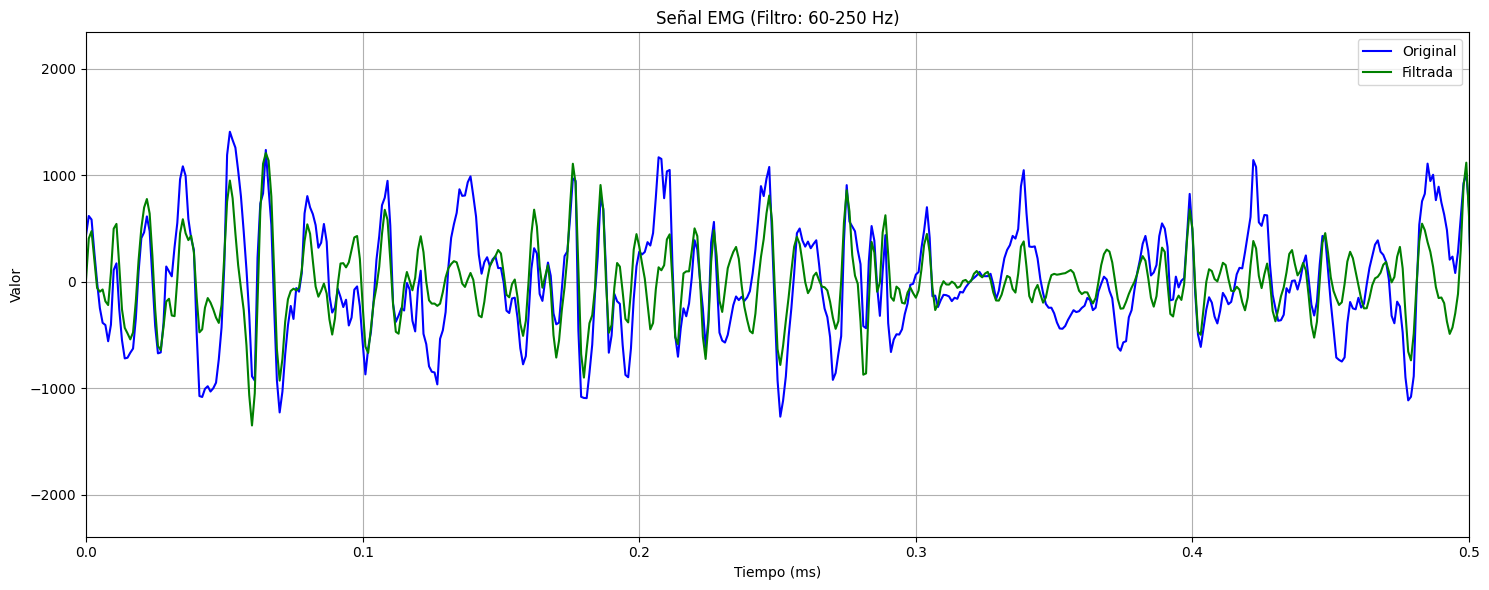

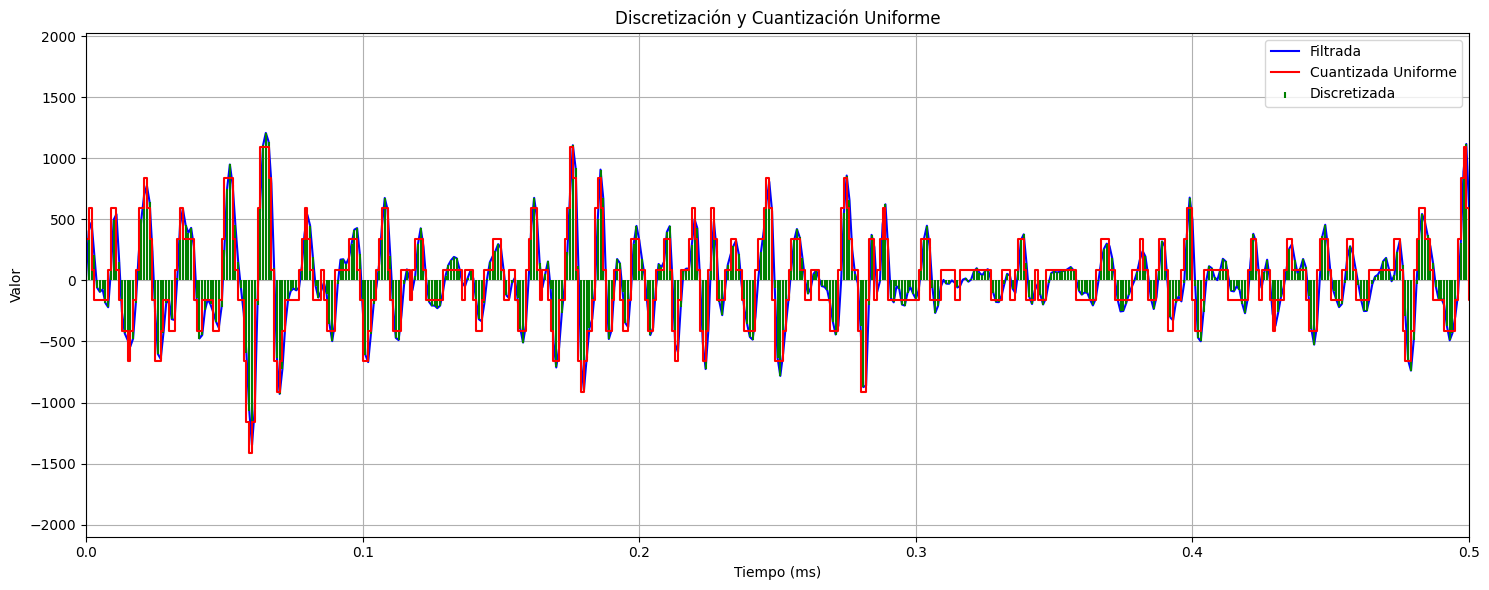

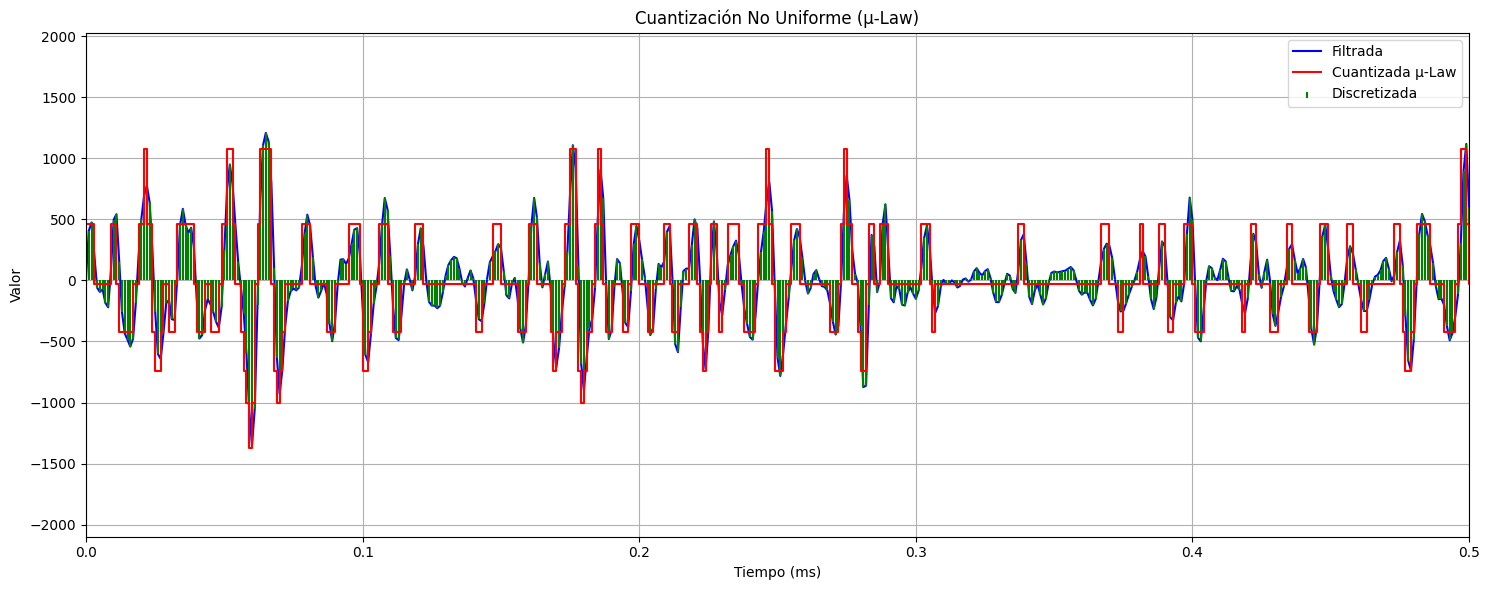

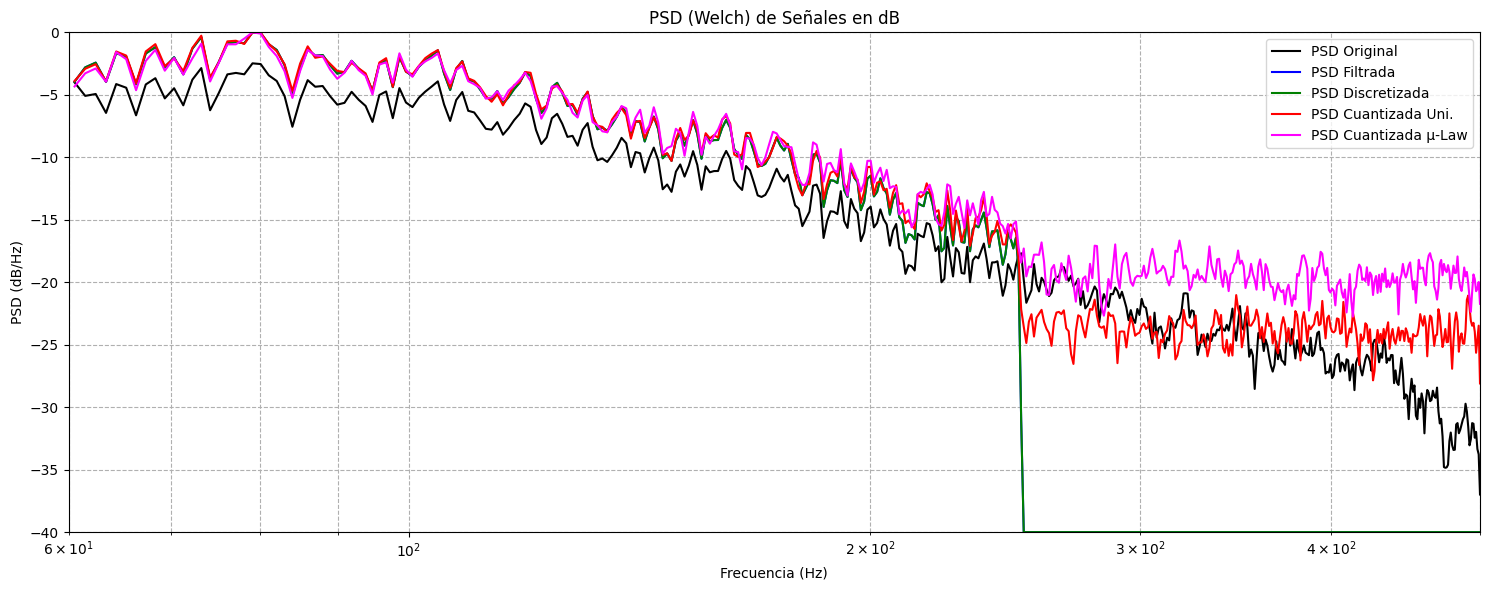

Cantidad de unos en la señal binarizada uniforme (toda la señal): 5286
Cantidad de ceros en la señal binarizada uniforme (toda la señal): 4214
Cantidad de unos en la señal binarizada no uniforme (toda la señal): 1986
Cantidad de ceros en la señal binarizada no uniforme (toda la señal): 7514


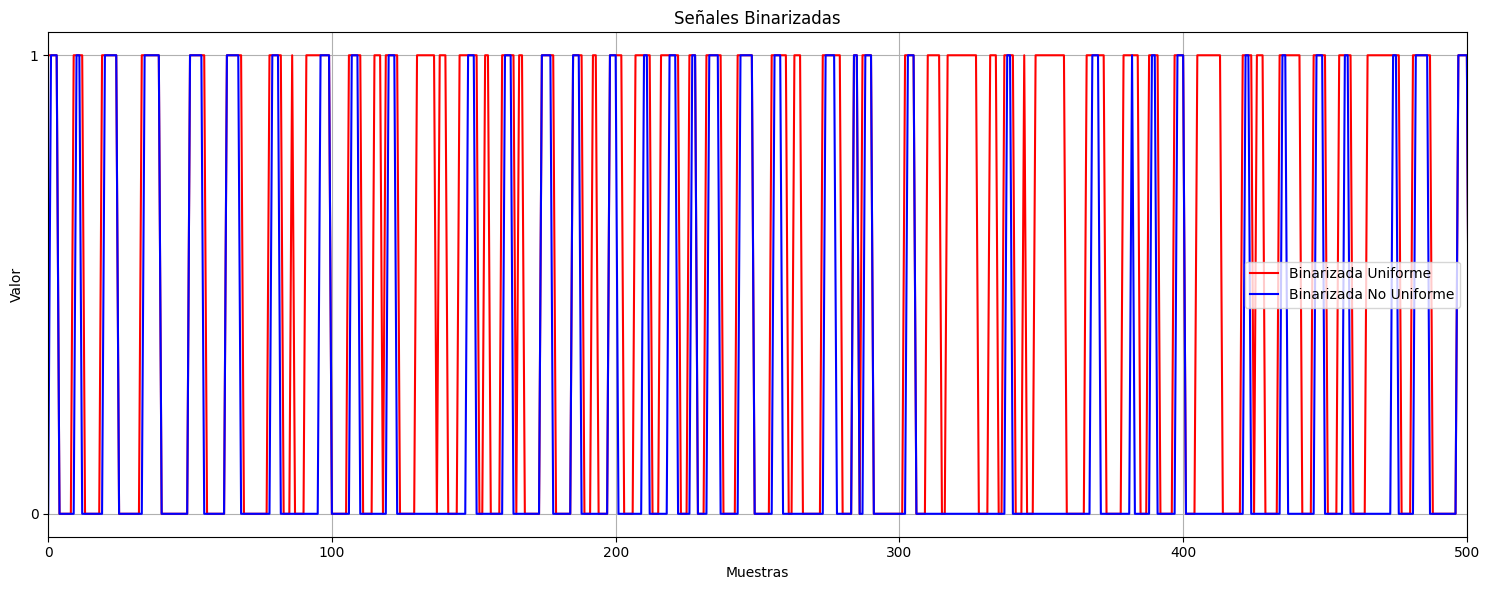

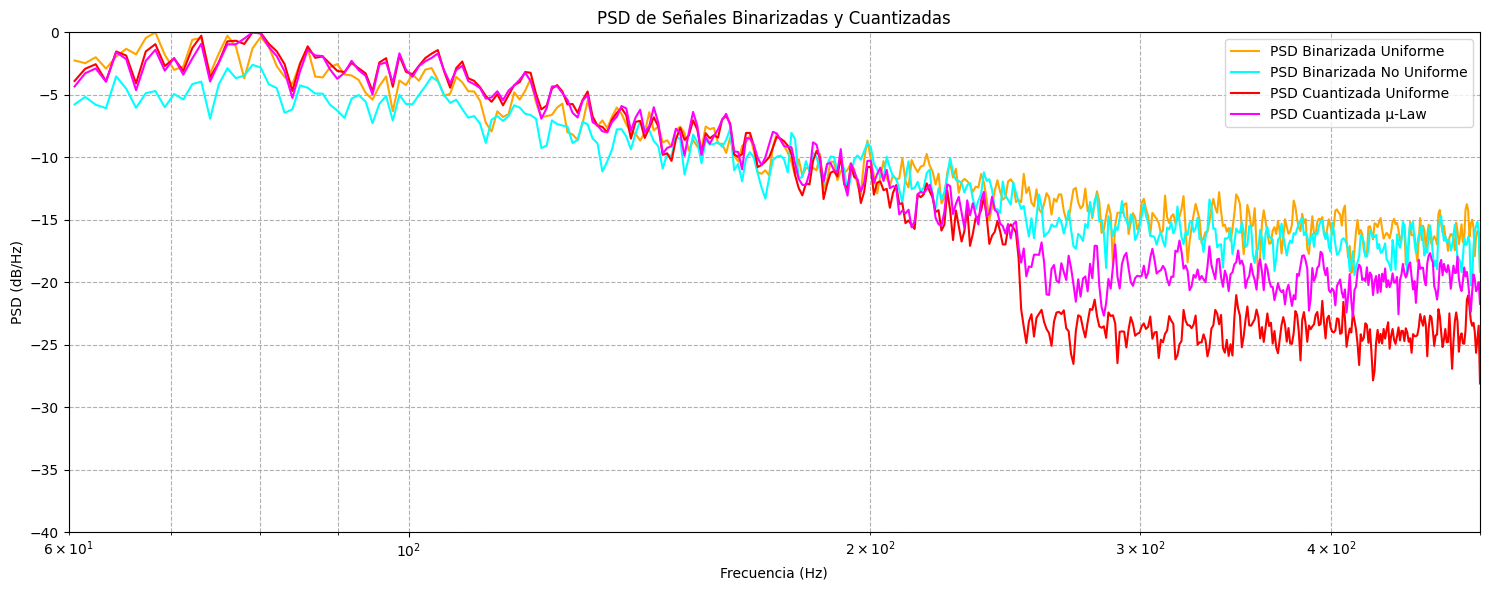

Uniform Quantization:
  Original length: 9500 bits
  Compressed length: 7444 bits
  Compression rate: 21.64%

μ-law Quantization:
  Original length: 9500 bits
  Compressed length: 5544 bits
  Compression rate: 41.64%


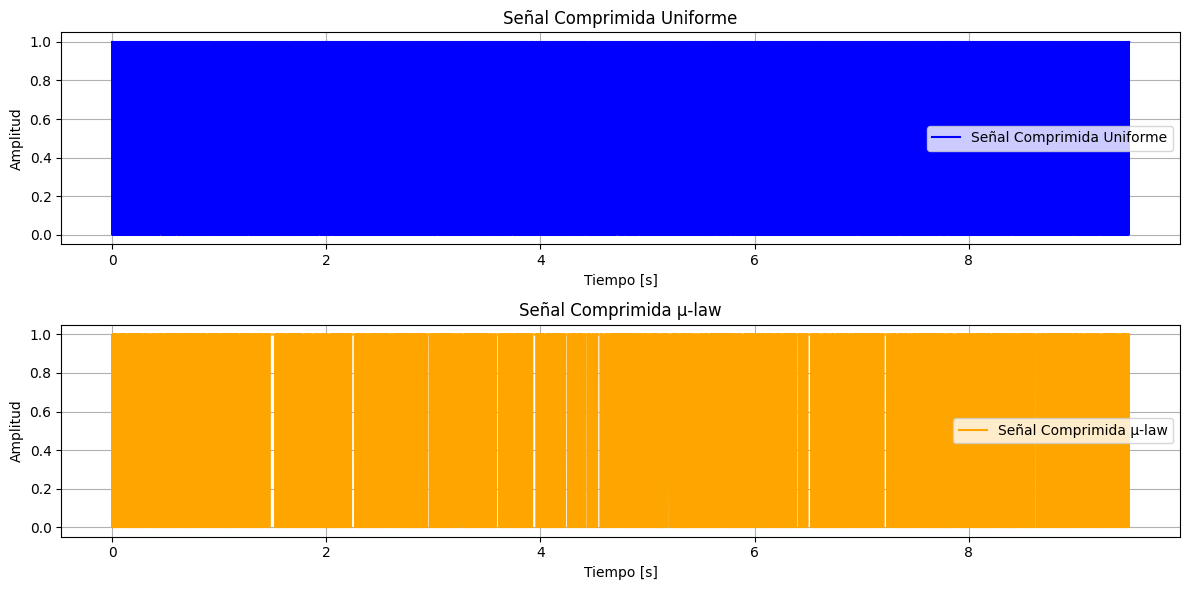

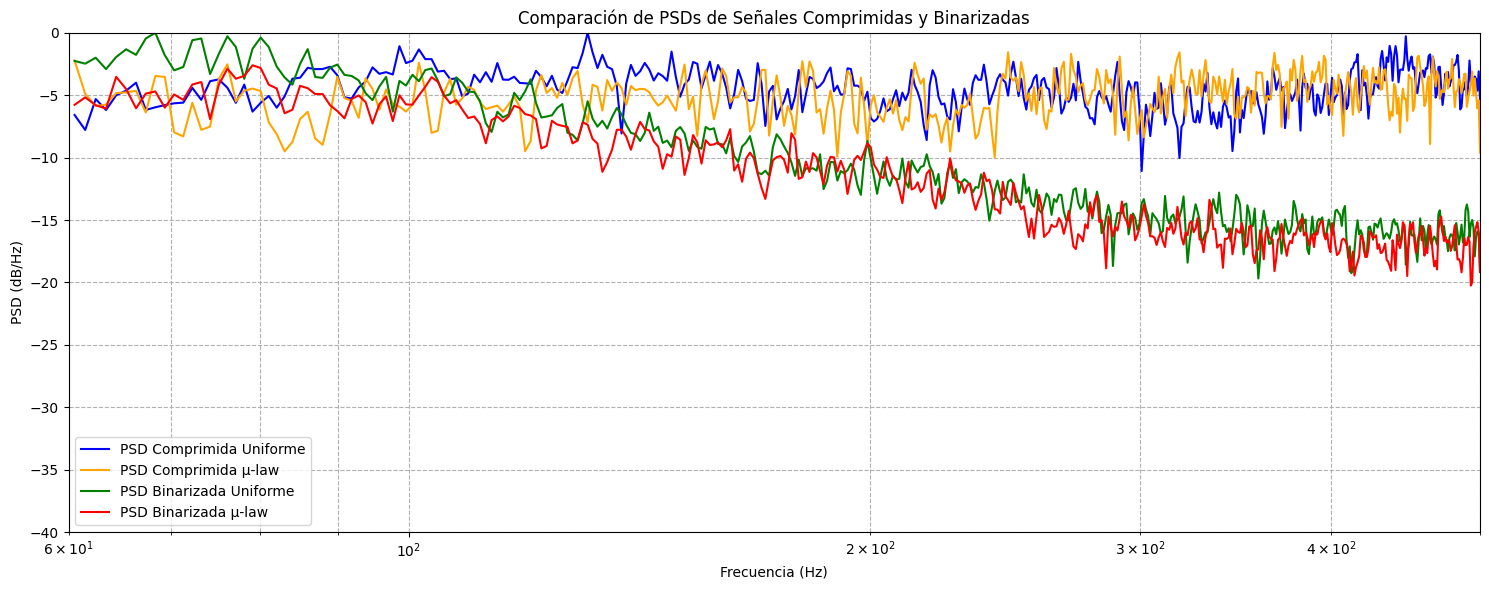

Antes del filtro - Uniforme: Ceros: 0, Unos: 0
Antes del filtro - μ-law: Ceros: 0, Unos: 0


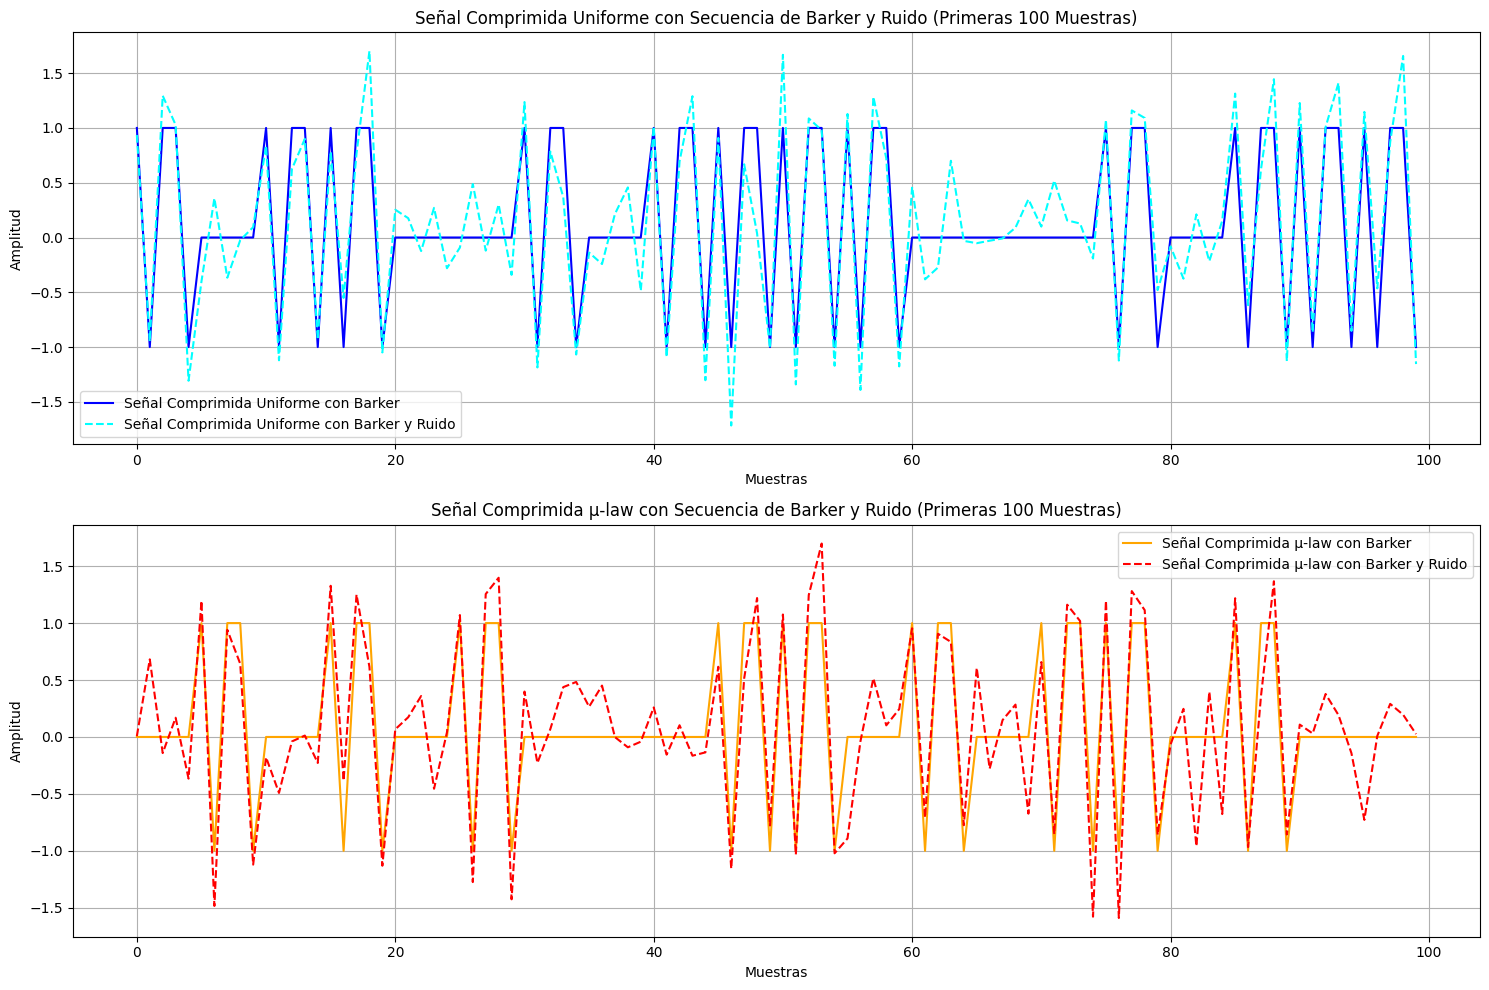

Después del filtro - Uniforme: Ceros: 7444, Unos: 0
Después del filtro - μ-law: Ceros: 5544, Unos: 0


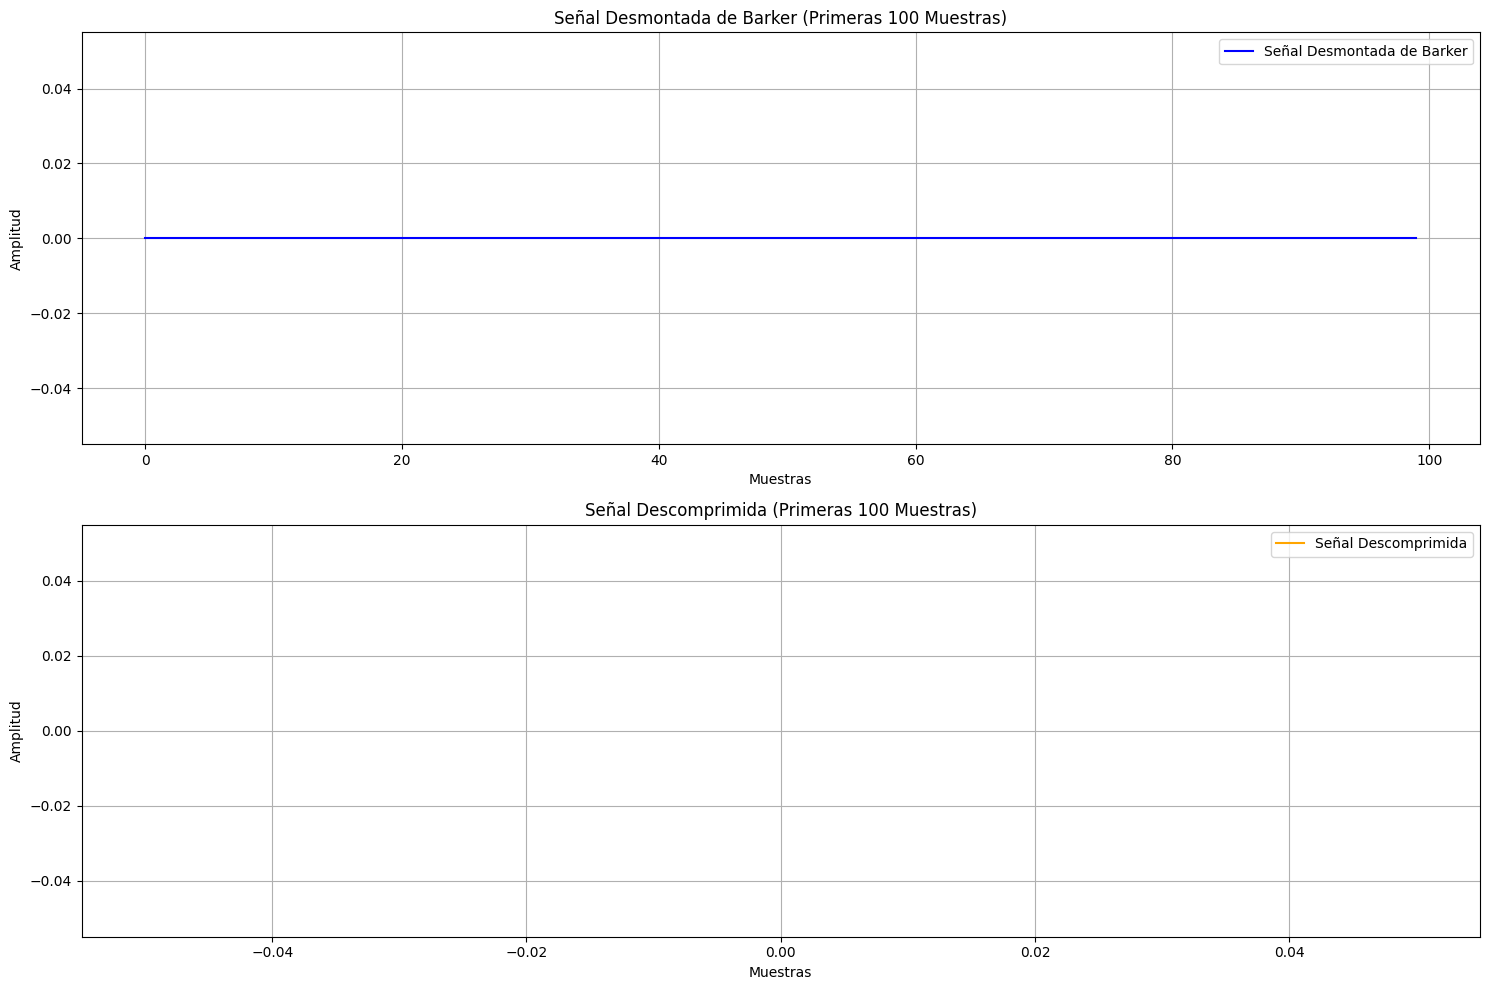

In [23]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import welch
from google.colab import drive

# Definición de las clases (TimeDomainProcessor, DiscreteQuantProcessor, PSDProcessor)
# Asegúrate de copiar aquí el código de las clases que has proporcionado.

class TimeDomainProcessor:
    """
    Carga, filtra y analiza la señal en el dominio del tiempo.
    """
    def __init__(self, csv_path, tiempo_a_graficar=0.3):
        self.csv_path = csv_path
        self.tiempo_a_graficar = tiempo_a_graficar
        self.tiempo = self.señal = None
        self.tiempo_filtrado = self.señal_filtrada = None
        self.N_filtrado = self.T = self.fs = None
        self.y_f = self.frecuencias = None
        self.f_min = self.f_max = None
        self.y_f_filtrado = self.señal_filtrada_freq = None

    def mount_drive(self):
        """Monta el drive de Google Colab."""
        drive.mount('/content/drive')

    def load_and_filter(self):
        """Carga el CSV, filtra la señal y calcula parámetros básicos."""
        try:
            datos = pd.read_csv(self.csv_path)
            print("Archivo CSV cargado exitosamente.")
        except Exception as e:
            print(f"Error al cargar el archivo CSV: {e}")
            exit()
        if 'Tiempo (ms)' in datos.columns and 'Datos Columna 2' in datos.columns:
            datos['Tiempo (ms)'] = pd.to_numeric(datos['Tiempo (ms)'], errors='coerce')
            self.tiempo = datos['Tiempo (ms)'].values
            self.señal = datos['Datos Columna 2'].values
            mask = self.tiempo <= self.tiempo_a_graficar
            self.tiempo_filtrado, self.señal_filtrada = self.tiempo[mask], self.señal[mask]
            self.N_filtrado = len(self.señal_filtrada)
            self.T = np.mean(np.diff(self.tiempo_filtrado))
            self.fs = 1 / self.T
            print(f"Puntos: {self.N_filtrado} | fs: {self.fs:.4f} Hz")
        else:
            print("Error: El CSV no contiene las columnas requeridas.")
            exit()

    def compute_fft(self):
        """Calcula la FFT de la señal filtrada."""
        self.y_f = fft(self.señal_filtrada)
        self.frecuencias = fftfreq(self.N_filtrado, d=self.T)
        positive_freqs = np.abs(self.frecuencias[self.frecuencias > 0])
        print(f"f_min: {np.min(positive_freqs):.4f} Hz | f_max: {np.max(positive_freqs):.4f} Hz")

    def apply_bandpass_filter(self, f_min, f_max):
        """
        Aplica un filtro pasabanda en el dominio de la frecuencia.

        Parameters:
            f_min (float): Frecuencia mínima.
            f_max (float): Frecuencia máxima.
        """
        self.f_min, self.f_max = f_min, f_max
        filtro = (np.abs(self.frecuencias) >= f_min) & (np.abs(self.frecuencias) <= f_max)
        self.y_f_filtrado = self.y_f * filtro
        self.señal_filtrada_freq = np.real(ifft(self.y_f_filtrado))
        print(f"Filtro: {f_min} Hz a {f_max} Hz")

    def plot_time_domain(self):
        """Grafica la señal original y la señal filtrada."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada, 'b-', label='Original')
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'g-', label='Filtrada')
        plt.title(f'Señal EMG (Filtro: {self.f_min}-{self.f_max} Hz)')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.xlim(0,0.5)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

class DiscreteQuantProcessor:
    """
    Realiza la discretización y cuantización (uniforme y μ‑Law) de la señal.
    """
    def __init__(self, tiempo_filtrado, señal_filtrada_freq):
        self.tiempo_filtrado = tiempo_filtrado
        self.señal_filtrada_freq = señal_filtrada_freq

    def discretize_signal(self, sampling_rate=1000):
        """Discretiza la señal por interpolación."""
        t_discreto = np.arange(self.tiempo_filtrado[0], self.tiempo_filtrado[-1], 1/sampling_rate)
        return t_discreto, np.interp(t_discreto, self.tiempo_filtrado, self.señal_filtrada_freq)

    @staticmethod
    def quantize_uniform(x, q_min, q_max, q_level):
        """Cuantización uniforme de la señal."""
        xn = (x - q_min) * (q_level - 1) / (q_max - q_min)
        return np.round(np.clip(xn, 0, q_level - 1)) * (q_max - q_min) / (q_level - 1) + q_min

    @staticmethod
    def quantize_mu_law(signal, L=16, mu=255, x_min=None, x_max=None):
        """Cuantización no uniforme usando la ley μ‑Law."""
        x_min = signal.min() if x_min is None else x_min
        x_max = signal.max() if x_max is None else x_max
        x_norm = (signal - x_min) / (x_max - x_min)
        companded = np.log1p(mu * x_norm) / np.log1p(mu)
        q_companded = np.round(companded * (L - 1)) / (L - 1)
        return (np.expm1(q_companded * np.log1p(mu)) / mu) * (x_max - x_min) + x_min

    def plot_discretized_quantized(self, t_discreto, señal_discreta, señal_quant_uniform):
        """Grafica la señal discretizada y cuantizada uniformemente."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Filtrada')
        plt.stem(t_discreto, señal_discreta, linefmt='g-', markerfmt=' ', basefmt=' ', label='Discretizada')
        plt.step(t_discreto, señal_quant_uniform, 'r-', label='Cuantizada Uniforme')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.title('Discretización y Cuantización Uniforme')
        plt.xlim(0,0.5)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_quantized_mu(self, t_discreto, señal_quant_mu):
        """Grafica la señal cuantizada con μ‑Law."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Filtrada')
        plt.stem(t_discreto, np.interp(t_discreto, self.tiempo_filtrado, self.señal_filtrada_freq),
                  linefmt='g-', markerfmt=' ', basefmt=' ', label='Discretizada')
        plt.step(t_discreto, señal_quant_mu, 'r-', label='Cuantizada μ‑Law')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.title('Cuantización No Uniforme (μ‑Law)')
        plt.xlim(0,0.5)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt

class PSDProcessor:
    """
    Calcula y grafica la densidad espectral de potencia (PSD) usando el método de Welch.
    """
    def __init__(self, fs, f_min):
        self.fs = fs
        self.f_min = f_min

    def compute_psd(self, signal):
        """Calcula la PSD usando el método de Welch."""
        n = min(1024, len(signal))
        f, psd = welch(signal, self.fs, nperseg=n)
        return f, psd

    def plot_psd(self, señal_original, señal_filtrada, señal_discreta, señal_qunif, señal_qmu, eps=1e-12):
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        f1, psd1 = calc_psd(señal_original)
        f2, psd2 = calc_psd(señal_filtrada)
        f3, psd3 = calc_psd(señal_discreta)
        f4, psd4 = calc_psd(señal_qunif)
        f5, psd5 = calc_psd(señal_qmu)

        plt.figure(figsize=(15, 6))
        for f, psd, label, col in zip([f1, f2, f3, f4, f5],
                                      [psd1, psd2, psd3, psd4, psd5],
                                      ['Original', 'Filtrada', 'Discretizada', 'Cuantizada Uni.', 'Cuantizada μ‑Law'],
                                      ['black', 'blue', 'green', 'red', 'magenta']):
            plt.plot(f[f >= self.f_min], psd[f >= self.f_min], color=col, label=f'PSD {label}')
        plt.title('PSD (Welch) de Señales en dB')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_binarized_psd(self, señal_binarizada_uni, señal_binarizada_no_uni, señal_qunif, señal_qmu, eps=1e-12):
        """
        Grafica la PSD de las señales binarizadas y las señales cuantizadas.
        """
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        f_binarizada_uni, psd_binarizada_uni = calc_psd(señal_binarizada_uni)
        f_binarizada_no_uni, psd_binarizada_no_uni = calc_psd(señal_binarizada_no_uni)
        f_qunif, psd_qunif = calc_psd(señal_qunif)
        f_qmu, psd_qmu = calc_psd(señal_qmu)

        plt.figure(figsize=(15, 6))
        plt.plot(f_binarizada_uni[f_binarizada_uni >= self.f_min], psd_binarizada_uni[f_binarizada_uni >= self.f_min], color='orange', label='PSD Binarizada Uniforme')
        plt.plot(f_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], psd_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], color='cyan', label='PSD Binarizada No Uniforme')
        plt.plot(f_qunif[f_qunif >= self.f_min], psd_qunif[f_qunif >= self.f_min], color='red', label='PSD Cuantizada Uniforme')
        plt.plot(f_qmu[f_qmu >= self.f_min], psd_qmu[f_qmu >= self.f_min], color='magenta', label='PSD Cuantizada μ-Law')

        plt.title('PSD de Señales Binarizadas y Cuantizadas')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_combined_psd(self, compressed_uniform, compressed_mu, señal_binarizada_uni, señal_binarizada_no_uni, eps=1e-12):
        """
        Grafica la PSD de las señales comprimidas y binarizadas en una sola gráfica.
        """
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        # Calcular PSDs
        f_compressed_uniform, psd_compressed_uniform = calc_psd(compressed_uniform)
        f_compressed_mu, psd_compressed_mu = calc_psd(compressed_mu)
        f_binarizada_uni, psd_binarizada_uni = calc_psd(señal_binarizada_uni)
        f_binarizada_no_uni, psd_binarizada_no_uni = calc_psd(señal_binarizada_no_uni)

        # Graficar
        plt.figure(figsize=(15, 6))  # Tamaño de figura consistente

        # Graficar PSD de la señal comprimida uniforme
        plt.plot(f_compressed_uniform[f_compressed_uniform >= self.f_min], psd_compressed_uniform[f_compressed_uniform >= self.f_min], color='blue', label='PSD Comprimida Uniforme')

        # Graficar PSD de la señal comprimida no uniforme
        plt.plot(f_compressed_mu[f_compressed_mu >= self.f_min], psd_compressed_mu[f_compressed_mu >= self.f_min], color='orange', label='PSD Comprimida μ-law')

        # Graficar PSD de la señal binarizada uniforme
        plt.plot(f_binarizada_uni[f_binarizada_uni >= self.f_min], psd_binarizada_uni[f_binarizada_uni >= self.f_min], color='green', label='PSD Binarizada Uniforme')

        # Graficar PSD de la señal binarizada no uniforme
        plt.plot(f_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], psd_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], color='red', label='PSD Binarizada μ-law')

        # Configuración de la gráfica
        plt.title('Comparación de PSDs de Señales Comprimidas y Binarizadas')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)  # Ajustar según sea necesario
        plt.ylim(-40, 0)  # Ajustar según sea necesario
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Nueva clase para Binarización
class Binarization:
    """
    Clase para binarizar la señal cuantizada.
    """
    def __init__(self, señal_cuantizada, señal_cuantizada_no_uniforme):
        self.señal_cuantizada = señal_cuantizada
        self.señal_cuantizada_no_uniforme = señal_cuantizada_no_uniforme
        self.señal_binarizada_uni = None
        self.señal_binarizada_no_uni = None

    def binarize(self, threshold=0):
        """
        Binariza la señal cuantizada usando un umbral.

        Parameters:
            threshold (float): Umbral para la binarización.
        """
        self.señal_binarizada_uni = np.where(self.señal_cuantizada > threshold, 1, 0)
        self.señal_binarizada_no_uni = np.where(self.señal_cuantizada_no_uniforme > threshold, 1, 0)

    def plot_binarized_signals(self):
        """Grafica las señales binarizadas."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.señal_binarizada_uni, 'r-', label='Binarizada Uniforme')
        plt.plot(self.señal_binarizada_no_uni, 'b-', label='Binarizada No Uniforme')
        plt.title('Señales Binarizadas')
        plt.xlabel('Muestras')
        plt.ylabel('Valor')
        plt.yticks([0, 1])
        plt.xlim(0,500)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

class HuffmanSignalAnalyzer:
    class Node:
        def __init__(self, symbol, freq, left=None, right=None):
            self.symbol = symbol
            self.freq = freq
            self.left = left
            self.right = right

        def __lt__(self, other):
            return self.freq < other.freq

    def __init__(self, binary_q_uniform, binary_q_mu, fs_binary, block_size):
        self.fs_binary = fs_binary
        self.block_size = block_size

        # Store original lengths.
        self.orig_uniform_len = len(binary_q_uniform)
        self.orig_mu_len = len(binary_q_mu)

        # Compress the binary signals by grouping bits into blocks and then applying Huffman coding.
        self.compressed_uniform, self.code_dict_uniform = self._huffman_compress(binary_q_uniform, block_size)
        self.compressed_mu, self.code_dict_mu = self._huffman_compress(binary_q_mu, block_size)

        # Store compressed lengths.
        self.comp_uniform_len = len(self.compressed_uniform)
        self.comp_mu_len = len(self.compressed_mu)

        # Compute the duration of the original binary signal.
        T = self.orig_uniform_len / fs_binary  # Assuming both signals share the same duration.

        # Compute effective bit rates (new "sampling frequencies") for the compressed signals.
        self.fs_uniform_compressed = self.comp_uniform_len / T
        self.fs_mu_compressed = self.comp_mu_len / T

        # Create time axes for the compressed signals.
        self.t_uniform_compressed = np.linspace(0, T, self.comp_uniform_len, endpoint=False)
        self.t_mu_compressed = np.linspace(0, T, self.comp_mu_len, endpoint=False)

    def _huffman_compress(self, binary_signal, block_size):
        n = len(binary_signal)
        n_blocks = n // block_size  # Discard any leftover bits.

        # Group bits into blocks and convert each block to a string symbol.
        symbols = []
        for i in range(n_blocks):
            block = binary_signal[i * block_size : (i + 1) * block_size]
            symbol = ''.join(str(bit) for bit in block)
            symbols.append(symbol)

        # Count the frequency of each symbol.
        freq = {}
        for s in symbols:
            freq[s] = freq.get(s, 0) + 1

        # Build the Huffman tree using a min-heap.
        heap = []
        for sym, f in freq.items():
            heapq.heappush(heap, self.Node(sym, f))
        if len(heap) == 1:
            sole_node = heapq.heappop(heap)
            code_dict = {sole_node.symbol: "0"}
        else:
            while len(heap) > 1:
                node1 = heapq.heappop(heap)
                node2 = heapq.heappop(heap)
                merged = self.Node(None, node1.freq + node2.freq, node1, node2)
                heapq.heappush(heap, merged)
            root = heap[0]
            code_dict = {}
            self._generate_codes(root, "", code_dict)

        # Encode the list of symbols using the Huffman codes.
        encoded_str = "".join(code_dict[s] for s in symbols)
        if encoded_str == "":
            return np.array([], dtype=int), code_dict
        compressed_array = np.array(list(encoded_str), dtype=int)
        return compressed_array, code_dict

    def _generate_codes(self, node, prefix, code_dict):
        if node is None:
            return
        if node.symbol is not None:  # Leaf node.
            code_dict[node.symbol] = prefix if prefix != "" else "0"
        else:
            self._generate_codes(node.left, prefix + "0", code_dict)
            self._generate_codes(node.right, prefix + "1", code_dict)

    def decompress(self, compressed_signal):
        """
        Descomprime la señal utilizando el diccionario de códigos de Huffman.

        Parameters:
            compressed_signal (np.ndarray): Señal comprimida.

        Returns:
            np.ndarray: Señal descomprimida.
        """
        bit_string = ''.join(map(str, compressed_signal))
        reverse_code_dict = {v: k for k, v in self.code_dict_uniform.items()}

        current_code = ""
        decompressed_signal = []

        for bit in bit_string:
            current_code += bit
            if current_code in reverse_code_dict:
                decompressed_signal.append(reverse_code_dict[current_code])
                current_code = ""

        decompressed_signal_flat = [int(bit) for block in decompressed_signal for bit in block]
        return np.array(decompressed_signal_flat)

    def print_compression_rate(self):
        if self.comp_uniform_len == 0 or self.comp_mu_len == 0:
            print("Compression failed: Compressed signal length is zero.")
            return

        compression_rate_uniform = (1 - self.comp_uniform_len / self.orig_uniform_len) * 100
        compression_rate_mu = (1 - self.comp_mu_len / self.orig_mu_len) * 100

        print("Uniform Quantization:")
        print(f"  Original length: {self.orig_uniform_len} bits")
        print(f"  Compressed length: {self.comp_uniform_len} bits")
        print(f"  Compression rate: {compression_rate_uniform:.2f}%")
        print()
        print("μ-law Quantization:")
        print(f"  Original length: {self.orig_mu_len} bits")
        print(f"  Compressed length: {self.comp_mu_len} bits")
        print(f"  Compression rate: {compression_rate_mu:.2f}%")

    def plot_compressed_signals(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 1, 1)
        plt.plot(self.t_uniform_compressed, self.compressed_uniform, label='Señal Comprimida Uniforme', color='blue')
        plt.title('Señal Comprimida Uniforme')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(self.t_mu_compressed, self.compressed_mu, label='Señal Comprimida μ-law', color='orange')
        plt.title('Señal Comprimida μ-law')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

import numpy as np
import matplotlib.pyplot as plt

class Barker:
    """
    Aplica la secuencia de Barker a las señales comprimidas y grafica los resultados.
    """
    def __init__(self, barker_sequence, compressed_uniform, compressed_mu, huffman_analyzer):
        self.barker_sequence = np.array(barker_sequence)
        self.compressed_uniform = compressed_uniform
        self.compressed_mu = compressed_mu
        self.huffman_analyzer = huffman_analyzer

    def apply_barker(self, signal):
        return np.concatenate([self.barker_sequence if bit == 1
                               else np.zeros_like(self.barker_sequence)
                               for bit in signal])

    def add_gaussian_noise(self, signal, power):
        noise = np.random.normal(0, np.sqrt(power), len(signal))
        return signal + noise

    def filter_signal(self, signal):
        count_ones = np.sum(signal == 1)
        count_zeros = np.sum(signal == 0)
        return count_zeros, count_ones

    def dismantle_barker(self, barker_signal):
        original_length = len(barker_signal) // len(self.barker_sequence)
        dismantled_signal = np.zeros(original_length)

        for i in range(original_length):
            if np.all(barker_signal[i * len(self.barker_sequence):(i + 1) * len(self.barker_sequence)] == self.barker_sequence):
                dismantled_signal[i] = 1
            else:
                dismantled_signal[i] = 0

        decompressed_signal = self.huffman_analyzer.decompress(dismantled_signal)
        return dismantled_signal, decompressed_signal

    def plot_signals(self):
        barker_uniform = self.apply_barker(self.compressed_uniform)
        barker_mu = self.apply_barker(self.compressed_mu)

        power_uniform = 0.1
        power_mu = 0.1
        barker_uniform_noisy = self.add_gaussian_noise(barker_uniform, power_uniform)
        barker_mu_noisy = self.add_gaussian_noise(barker_mu, power_mu)

        count_zeros_uniform, count_ones_uniform = self.filter_signal(barker_uniform_noisy)
        count_zeros_mu, count_ones_mu = self.filter_signal(barker_mu_noisy)
        print(f"Antes del filtro - Uniforme: Ceros: {count_zeros_uniform}, Unos: {count_ones_uniform}")
        print(f"Antes del filtro - μ-law: Ceros: {count_zeros_mu}, Unos: {count_ones_mu}")

        plt.figure(figsize=(15, 10))

        plt.subplot(2, 1, 1)
        plt.plot(barker_uniform[:100], label='Señal Comprimida Uniforme con Barker', color='blue')
        plt.plot(barker_uniform_noisy[:100], label='Señal Comprimida Uniforme con Barker y Ruido', color='cyan', linestyle='--')
        plt.title('Señal Comprimida Uniforme con Secuencia de Barker y Ruido (Primeras 100 Muestras)')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(barker_mu[:100], label='Señal Comprimida μ-law con Barker', color='orange')
        plt.plot(barker_mu_noisy[:100], label='Señal Comprimida μ-law con Barker y Ruido', color='red', linestyle='--')
        plt.title('Señal Comprimida μ-law con Secuencia de Barker y Ruido (Primeras 100 Muestras)')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

        dismantled_uniform, decompressed_uniform = self.dismantle_barker(barker_uniform_noisy)
        dismantled_mu, decompressed_mu = self.dismantle_barker(barker_mu_noisy)

        count_zeros_dismantled_uniform, count_ones_dismantled_uniform = self.filter_signal(dismantled_uniform)
        count_zeros_dismantled_mu, count_ones_dismantled_mu = self.filter_signal(dismantled_mu)
        print(f"Después del filtro - Uniforme: Ceros: {count_zeros_dismantled_uniform}, Unos: {count_ones_dismantled_uniform}")
        print(f"Después del filtro - μ-law: Ceros: {count_zeros_dismantled_mu}, Unos: {count_ones_dismantled_mu}")

        plt.figure(figsize=(15, 10))

        plt.subplot(2, 1, 1)
        plt.plot(dismantled_uniform[:100], label='Señal Desmontada de Barker', color='blue')
        plt.title('Señal Desmontada de Barker (Primeras 100 Muestras)')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(decompressed_uniform[:100], label='Señal Descomprimida', color='orange')
        plt.title('Señal Descomprimida (Primeras 100 Muestras)')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

# =============================================================================
# Ejecución principal
# =============================================================================
if __name__ == "__main__":
    # Ruta del archivo CSV
    csv_path = "/content/drive/MyDrive/Signal Theory/Running_Columna_2_Tiempo.csv"

    # Crear instancia de TimeDomainProcessor
    tdp = TimeDomainProcessor(csv_path, tiempo_a_graficar=9.5)
    tdp.mount_drive()
    tdp.load_and_filter()

    # Calcular FFT antes de aplicar el filtro
    tdp.compute_fft()

    # Definir frecuencias para el filtro
    f_min = 60
    f_max = 250
    tdp.apply_bandpass_filter(f_min, f_max)
    tdp.plot_time_domain()

    # Crear instancia de DiscreteQuantProcessor
    dq = DiscreteQuantProcessor(tdp.tiempo_filtrado, tdp.señal_filtrada_freq)
    t_discreto, señal_discreta = dq.discretize_signal(sampling_rate=1000)
    num_bits, levels = 4, 2 ** 4
    q_min, q_max = señal_discreta.min(), señal_discreta.max()
    señal_qunif = dq.quantize_uniform(señal_discreta, q_min, q_max, levels)
    señal_qmu = dq.quantize_mu_law(señal_discreta, L=levels, mu=25)

    dq.plot_discretized_quantized(t_discreto, señal_discreta, señal_qunif)
    dq.plot_quantized_mu(t_discreto, señal_qmu)

    # Crear instancia de PSDProcessor
    psd_processor = PSDProcessor(tdp.fs, f_min)
    psd_processor.plot_psd(tdp.señal_filtrada, tdp.señal_filtrada_freq,
                            señal_discreta, señal_qunif, señal_qmu)

    # Crear instancia de Binarization
    binarization = Binarization(señal_qunif, señal_qmu)
    binarization.binarize(threshold=0)

    # Contar la cantidad de unos y ceros en las señales binarizadas completas
    num_unos_uni = np.sum(binarization.señal_binarizada_uni)
    num_ceros_uni = len(binarization.señal_binarizada_uni) - num_unos_uni

    num_unos_no_uni = np.sum(binarization.señal_binarizada_no_uni)
    num_ceros_no_uni = len(binarization.señal_binarizada_no_uni) - num_unos_no_uni

    # Imprimir la cantidad de unos y ceros
    print(f"Cantidad de unos en la señal binarizada uniforme (toda la señal): {num_unos_uni}")
    print(f"Cantidad de ceros en la señal binarizada uniforme (toda la señal): {num_ceros_uni}")
    print(f"Cantidad de unos en la señal binarizada no uniforme (toda la señal): {num_unos_no_uni}")
    print(f"Cantidad de ceros en la señal binarizada no uniforme (toda la señal): {num_ceros_no_uni}")

    # Graficar las señales binarizadas
    binarization.plot_binarized_signals()

    # Graficar la PSD de las señales binarizadas y cuantizadas
    psd_processor.plot_binarized_psd(binarization.señal_binarizada_uni,
                                      binarization.señal_binarizada_no_uni,
                                      señal_qunif, señal_qmu)

    # Instanciar HuffmanSignalAnalyzer
    block_size = 4  # Define el tamaño del bloque (número de bits por símbolo)
    huffman_analyzer = HuffmanSignalAnalyzer(binarization.señal_binarizada_uni,
                                             binarization.señal_binarizada_no_uni,
                                             fs_binary=tdp.fs,  # Usa la frecuencia de muestreo original
                                             block_size=block_size)

    # Imprimir la tasa de compresión
    huffman_analyzer.print_compression_rate()

    # Graficar las señales comprimidas
    huffman_analyzer.plot_compressed_signals()

    # Graficar la PSD de las señales comprimidas y binarizadas
    psd_processor.plot_combined_psd(huffman_analyzer.compressed_uniform,
                                    huffman_analyzer.compressed_mu,
                                    binarization.señal_binarizada_uni,
                                    binarization.señal_binarizada_no_uni)

    # Definir la secuencia de Barker (ejemplo)
    barker_sequence = [1, -1, 1, 1, -1]  # Puedes ajustar esta secuencia según sea necesario

    # Instanciar la clase Barker con las señales comprimidas y el analizador de Huffman
    barker_processor = Barker(barker_sequence, huffman_analyzer.compressed_uniform, huffman_analyzer.compressed_mu, huffman_analyzer)

    # Graficar las señales
    barker_processor.plot_signals()

